In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

1.1

In [168]:
# 1.1
children_count = movies[movies['genres'].str.contains('Children')].shape[0]

print("Liczba filmów dla dzieci:", children_count)

Liczba filmów dla dzieci: 664


1.2

C:\Users\hawry\AppData\Local\Temp\ipykernel_10508\4200505361.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  movies_1995 = movies[movies['title'].str.contains('(1995)', case=False)]
C:\Users\hawry\AppData\Local\Temp\ipykernel_10508\4200505361.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=movies_1995_ratings, palette="viridis")


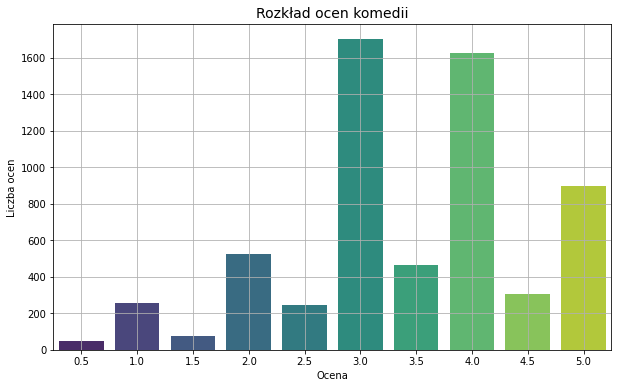

In [170]:
import seaborn as sns
import matplotlib.pyplot as plt

movies_1995 = movies[movies['title'].str.contains('(1995)', case=False)]
movies_1995_ratings = pd.merge(movies_1995, ratings, on='movieId', how='inner')
movies_1995_ratings_distribution = movies_1995_ratings['rating'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.countplot(x="rating", data=movies_1995_ratings, palette="viridis")
plt.title("Rozkład ocen komedii", fontsize=14)
plt.xlabel("Ocena")
plt.ylabel("Liczba ocen")
plt.grid(True)
plt.show()

1.3

In [171]:
action_movies = movies[movies['genres'].str.contains('Action')]

action_ratings = pd.merge(action_movies, ratings, on='movieId')

average_rating_action = action_ratings['rating'].mean()

top_three_movies = action_ratings.groupby('title')['rating'].mean().nlargest(3)

print("Średnia ocena wszystkich filmów akcji:", average_rating_action)
print("\n3 filmy najwyżej oceniane (z filmów akcji):")
print(top_three_movies)

Średnia ocena wszystkich filmów akcji: 3.447984331646809

3 filmy najwyżej oceniane (z filmów akcji):
title
Alien Contamination (1980)                                         5.0
Assignment, The (1997)                                             5.0
Battle Royale 2: Requiem (Batoru rowaiaru II: Chinkonka) (2003)    5.0
Name: rating, dtype: float64


2

In [172]:
from surprise import Dataset, Reader, SVD, KNNWithMeans
from surprise.model_selection import cross_validate, GridSearchCV


merged_data = pd.merge(ratings, movies, on='movieId')

reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(merged_data[['userId', 'movieId', 'rating']], reader)

svd = SVD()
knn = KNNWithMeans()

param_grid_knn = {'k': list(range(3, 11))}
gs_knn = GridSearchCV(KNNWithMeans, param_grid_knn, measures=['rmse', 'mae'], cv=5)
gs_knn.fit(data)

print("kNNWithMeans:")
print(gs_knn.best_score['rmse'])
print(gs_knn.best_params['rmse'])

svd_cv_results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
knn_cv_results = cross_validate(KNNWithMeans(k=gs_knn.best_params['rmse']['k']), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

svd_avg_rmse = svd_cv_results['test_rmse'].mean()
svd_avg_mae = svd_cv_results['test_mae'].mean()
knn_avg_rmse = knn_cv_results['test_rmse'].mean()
knn_avg_mae = knn_cv_results['test_mae'].mean()

print("\nWalidacja krzyżowa:")
print("SVD:")
print("Średnie RMSE:", svd_avg_rmse)
print("Średnie MAE:", svd_avg_mae)
print("\nkNNWithMeans:")
print("Średnie RMSE:", knn_avg_rmse)
print("Średnie MAE:", knn_avg_mae)


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

2.2 kNNWithMeans to algorytm grupowania (clustering), natomiast standardowy kNN to algorytm klasyfikacji

2.3 i 2.4: SVD ma mniejszy RMSE oraz MAE od kNNWithMeans (k=10, GridSearch)

3

In [179]:
movie_mapper = dict(zip(movies['title'], movies['movieId']))

def find_movies_by_title(partial_titles, movie_mapper):
    matching_movies = []
    partial_titles_lower = [partial_title for partial_title in partial_titles]
    for title, movie_id in movie_mapper.items():
        title_lower = title
        if any(partial_title in title_lower for partial_title in partial_titles_lower):
            matching_movies.append((title, movie_id))
    return matching_movies

partial_titles = ["NeverEnding Story III", "Pi "]
matching_movies = find_movies_by_title(partial_titles, movie_mapper)

if matching_movies:
    print("Znalezione filmy:")
    for title, movie_id in matching_movies:
        print(f"ID: {movie_id}, Tytuł: {title}")
else:
    print("Nie znaleziono")


Znalezione filmy:
ID: 126, Tytuł: NeverEnding Story III, The (1994)
ID: 1921, Tytuł: Pi (1998)
ID: 97938, Tytuł: Life of Pi (2012)


In [186]:
import numpy as np
def get_similar_movies_svd(movie_id, svd_model, N=10):
    movie_inner_id = svd_model.trainset.to_inner_iid(movie_id)
    movie_vector = svd_model.qi[movie_inner_id]
    similarity_scores = np.dot(svd_model.qi, movie_vector)

    similar_movie_indices = similarity_scores.argsort()[::-1][1:N+1]
    similar_movie_ids = [svd_model.trainset.to_raw_iid(inner_id) for inner_id in similar_movie_indices]

    return similar_movie_ids

similar_movies_svd = get_similar_movies_svd(126, svd)

movie_title = movies[movies['movieId'] == 126]['title'].values[0]

print(f"Rekomendacje po obejrzeniu {movie_title}:")
for movie_id in similar_movies_svd:
    movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
    print(movie_title)

Rekomendacje po obejrzeniu NeverEnding Story III, The (1994):
Emmanuelle (1974)
Vie en Rose, La (Môme, La) (2007)
Universal Soldier: The Return (1999)
Before Midnight (2013)
3 Ninjas (1992)
Men in Black (a.k.a. MIB) (1997)
Brady Bunch Movie, The (1995)
Jumpin' Jack Flash (1986)
Planes, Trains & Automobiles (1987)
Dances with Wolves (1990)


In [185]:
similar_movies_svd = get_similar_movies_svd(1921, svd)

movie_title = movies[movies['movieId'] == 1921]['title'].values[0]

print(f"Rekomendacje po obejrzeniu {movie_title}:")
for movie_id in similar_movies_svd:
    movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
    print(movie_title)

Rekomendacje po obejrzeniu Pi (1998):
Truman Show, The (1998)
Under Siege (1992)
The Intern (2015)
Mystery Science Theater 3000: The Movie (1996)
Young Frankenstein (1974)
Metroland (1997)
True Romance (1993)
Annie Hall (1977)
F/X (1986)
Harry Potter and the Deathly Hallows: Part 2 (2011)
